In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [3]:
data_dir = 'word2vec_data/words'
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [4]:
def fetch_words_data(url = data_url, words_data = data_dir):
    #make the Dir if it does not exist
    os.makedirs(words_data, exist_ok = True)
    
    #patch the zip file
    zip_path = os.path.join(words_data, 'words.zip')
    
    #if the zip file isn't there download it from url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    
    #now that the zip file is there, get the data 
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    #return a list of all the words in the data source
    return data.decode('ascii').split()

In [5]:
words = fetch_words_data()

In [6]:
len(words)

17005207

In [7]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [8]:
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [9]:
from collections import Counter

In [10]:
my_list = ["one", "two", 'two']

In [11]:
Counter(my_list)

Counter({'one': 1, 'two': 2})

In [13]:
#Create word data and vocabulary

def create_counts(vocab_size=50000):
    #gram 50k most common word that will be my vocab
    vocab = [] + Counter(words).most_common(vocab_size)
    
    #tuple unpacking
    vocab = np.array([word for word, _ in vocab ])
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data, vocab

In [14]:
data, vocabulary = create_counts()

In [15]:
data.shape

(17005207,)

In [16]:
vocabulary.shape

(50000,)

In [17]:
words[100]

'interpretations'

In [18]:
data[100] #index position of word[100]

4186

In [ ]:
#generate a battch

In [46]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window +1 #skip window target skip_window
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        
        target = skip_window #target label at center of buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips +j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [23]:
#contants

batch_size = 128
embedding_size = 150
skip_window = 1 # how many word to consider on left and right
num_skips = 2 #how many time take a input to generate labels

In [24]:
valid_size = 16 #random set of word to show similarity
valid_window = 100
#here we are limiting the validation sample words having low numerid id
#can contruct most frequest word
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [25]:
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50000

In [26]:
tf.reset_default_graph()

In [27]:
#inputs int this time
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype = tf.int32)

In [28]:
#randomly choose value from -1.0,1.0 
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0,1.0)

embeddings = tf.Variable(init_embeds)

In [30]:
embeddings = tf.Variable(init_embeds)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [32]:
#creating weight
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0/np.sqrt(embedding_size)))

In [33]:
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [34]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1.0)
trainer = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [41]:
#compute the cosine similarity betweem minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalizd_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalizd_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalizd_embeddings, transpose_b = True)

In [42]:
data_index = 0
init = tf.global_variables_initializer()

In [48]:
num_steps = 5000
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels:batch_labels}
        
        _, loss_val = sess.run([trainer,loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss/1000
            print("AVerage loss at ", step, "is: ", average_loss)
            average_loss = 0
            
        final_embeddings = normalizd_embeddings.eval()

AVerage loss at  0 is:  283.1471252441406
AVerage loss at  1000 is:  10401.594140213012
AVerage loss at  2000 is:  23238.62972127533
AVerage loss at  3000 is:  27082.601450275422
AVerage loss at  4000 is:  31209.909001464843


In [49]:
#display
final_embeddings.shape

(50000, 150)

In [51]:
from sklearn.manifold import TSNE #transform into 2d from 3d
tnse = TSNE(perplexity = 30, n_components =2, init = 'pca', n_iter=5000)
plot_only = 500
low_dim_embed = tnse.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
low_dim_embed.shape

(500, 2)

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18,18)) #inch
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points',
                  ha='right', va='bottom')

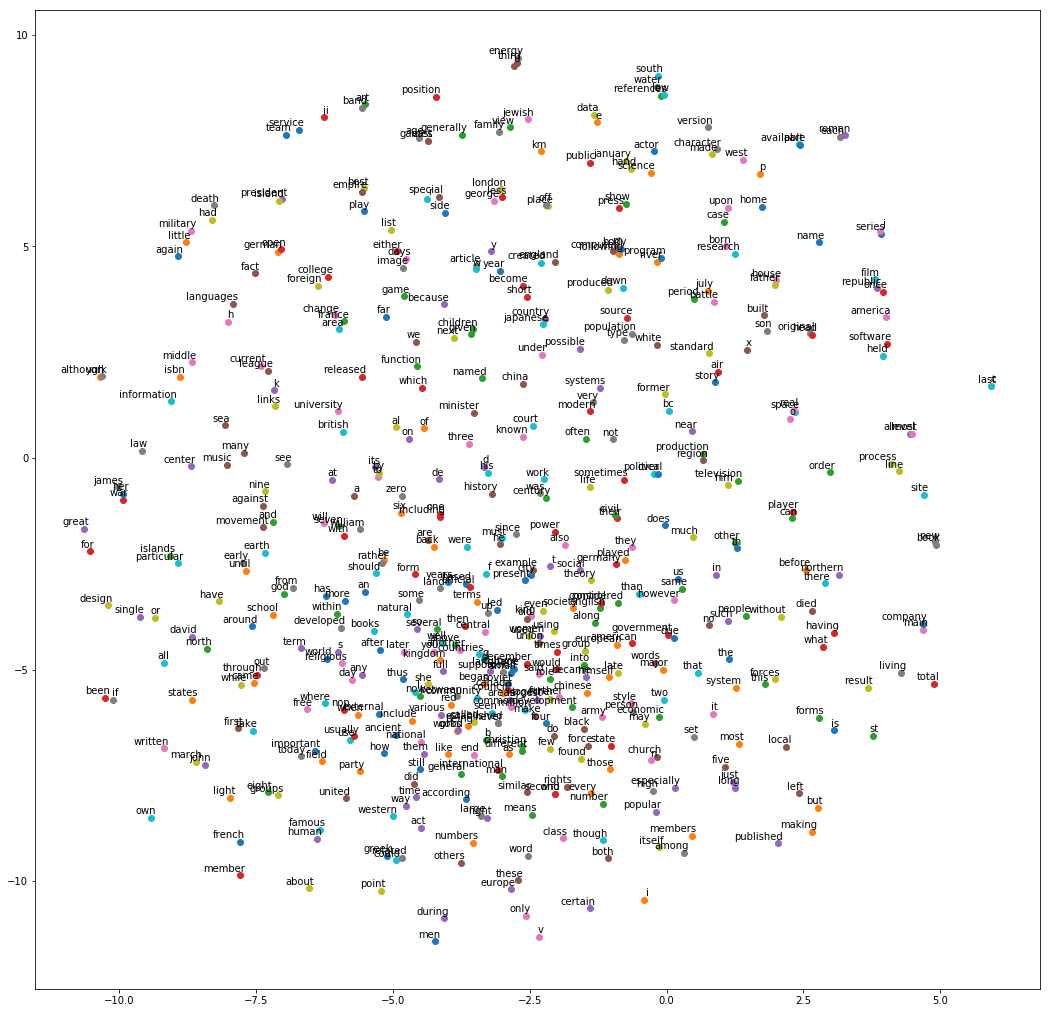

In [55]:
plot_with_labels(low_dim_embed, labels)

In [ ]:
#to load another trained embedding
#final_embeddings = np.load('trained_embeddings_200k_steps.npy')